In [2]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib, tarfile, shutil, os, glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

%matplotlib inline
from IPython.display import HTML
HTML('''<script> code_show=true; 
function code_toggle() {
if (code_show){$('div.input').hide();}
else {$('div.input').show();}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script> To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')                             

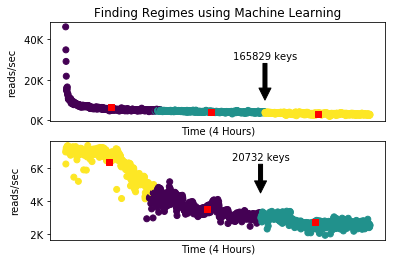

In [41]:
def untar(fname):
    try: shutil.rmtree("tmp")
    except: pass
    os.mkdir("tmp")
    tar = tarfile.open(fname)
    tar.extractall()
    tar.close()
    
def get_nth_val(op, results, rank="1", label="", begin=""):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    df = df[df['op'] == op]
    shift = np.min(df['ts']) * np.ones(len(df['ts']))
    df['shift'] = df['ts'].astype(float) - shift
    keys = df[df['shift'] > begin*10].head(1)['count']
    return keys
    
    
def plot_kmeans(ax, op, results, rank="1", label="", y=(3000, 1000)):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    
    df = df[df['op'] == op]
    shift = np.min(df['ts']) * np.ones(len(df['ts']))
    
    df['cs'] = df['count'].astype(float) - df['count'].shift(1).astype(float)
    
    # calculate kmeans
    f1 = df['ts'].astype(float) - shift
    f2 = df['cs'].astype(float)
    X=np.matrix(zip(f1, f2.fillna(0)))
    kmeans = KMeans(n_clusters=3).fit(X)
    ax.scatter(f1, f2, label=label, c=kmeans.labels_)
    for c in kmeans.cluster_centers_:
        ax.scatter(c[0], c[1], color='red', marker='s')
        
        
        
    
    ax.set_xlabel("Time (4 Hours)")
    ax.set_xticks([])
    ax.legend()
    
    seen = [kmeans.labels_[0]]
    begin = -1
    end = -1
    # get the 3rd regime
    for i in kmeans.labels_:
        if i not in seen:
            seen.append(i)
            if len(seen) == 3:
                begin = i
            elif len(seen) == 4:
                end = i
                break
    #print seen
    #print np.where(kmeans.labels_==begin)[0][0]
    #print np.where(kmeans.labels_==end)[0][0]


    # Memory Map Size
    keys = get_nth_val("DBMemoryMapSize", results, begin=np.where(kmeans.labels_==begin)[0][0])
    #print keys
    x = np.where(kmeans.labels_==begin)[0][0]
    #print "begin=" + str(x)
    ax.annotate(str(int(keys)) + " keys", xy=(x*10, y[1]), xytext=(x*10, y[0]),
                arrowprops=dict(facecolor='black'), ha="center")
    ax.set_ylabel("reads/sec")
    ax.set_yticklabels(['{:3.0f}K'.format(yval/(1000)) for yval in ax.get_yticks()])

fig, ax = plt.subplots(2, 1)#, figsize=(8, 4))
d = "../experiments/baseline-trinitite/"
plot_kmeans(ax[0], "DBMemoryGet", d+"nano-sepminima/scale-mantle-workers/scale-mantle-unlimited-71705",
           y=(30000, 10000))
#plot_kmeans(ax[0], "DBMemoryGet", d+"nano-sepminima/scale-keyspace-trace/scale-workers-4-71541/", label="4N, 100K")
#plot_kmeans(ax[1], "DBMemoryGet", d+"nano-sepminima/scale-keyspace-trace/scale-workers-4-71541/", label="1N, 100K")
plot_kmeans(ax[1], "DBMemoryGet", d+"nano-sepminima/scale-keyspace-trace/scale-workers-1M-4-71537/", 
            y=(6500, 4500))
#plot_kmeans(ax[3], "DBMemoryGet", d+"nano-sepminima/scale-keyspace-trace/scale-workers-1M-1-71684", label="1N, 1M")
ax[0].set_title("Finding Regimes using Machine Learning")
#fig.savefig("../paper/figures/futurework-regimes.png", bbox_inches='tight', dpi=400)

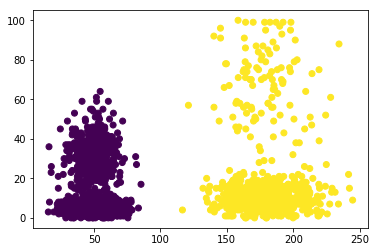

In [181]:
from sklearn.cluster import KMeans

df = pd.read_csv("./data_1024.csv", sep='\t')

### For the purposes of this example, we store feature data from our
### dataframe `df`, in the `f1` and `f2` arrays. We combine this into
### a feature matrix `X` before entering it into the algorithm.
f1 = df['Distance_Feature'].values
f2 = df['Speeding_Feature'].values

X=np.matrix(zip(f1,f2))
kmeans = KMeans(n_clusters=2).fit(X)
kmeans.labels_

fig, ax = plt.subplots(1, 1)
ax.scatter(df['Distance_Feature'], df['Speeding_Feature'], c=kmeans.labels_)